In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
import glob

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [3]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [4]:
#read NEA dengue data
df_00_11 = pd.read_csv("Dengue_2000-2011.csv")
df_12 = pd.read_csv("Dengue_2012.csv")
df_13 = pd.read_csv("Dengue_2013.csv")
df_14 = pd.read_csv("Dengue_2014.csv")
df_15 = pd.read_csv("Dengue_2015.csv")

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
frames = [df_00_11, df_12, df_13, df_14, df_15]
df_all = pd.concat(frames)
df_all = df_all.dropna(subset=["ONSET_DATE"])
df_all["ONSET_DATE"] = pd.to_datetime(df_all["ONSET_DATE"], errors='coerce')

In [6]:
df_all['dateindex'] = df_all["ONSET_DATE"]
df_all.set_index(df_all['dateindex'], inplace=True)
df_all.dateindex = pd.to_datetime(df_all.dateindex, unit='s')

In [7]:
#drop rows with no date or unreasonable dates
date_lower = datetime.date(1990,1,1)
df_all=df_all[~df_all['dateindex'].isna()]
df_all=df_all[df_all['dateindex'] > date_lower]

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.


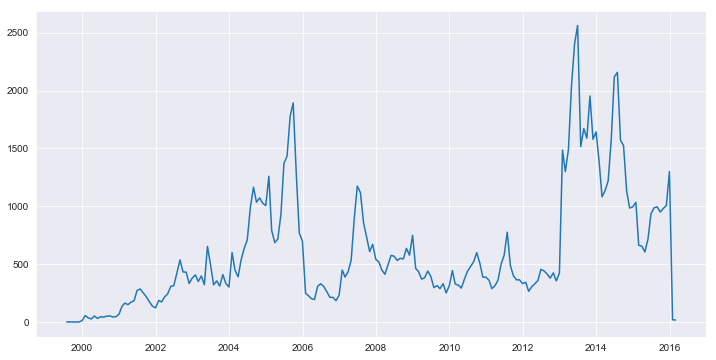

In [188]:
plt.figure(figsize=(12, 6))
df_m = df_all["OBJECTID"].resample('m',level=0).count()
lgd = ['Weekly','Monthly','Quarterly']
plt.plot(df_m)


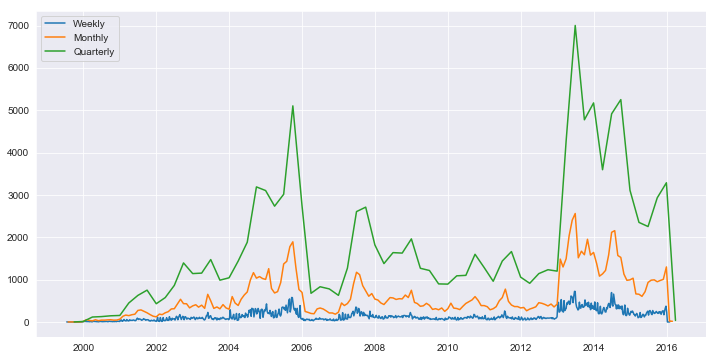

In [98]:
plt.figure(figsize=(12, 6))
sampling_freq = ['W','M','Q']
df_all.sort_index(ascending=True, inplace=True)
    
df_w = df_all["OBJECTID"].resample('w',level=0).count()
lgd = ['Weekly','Monthly','Quarterly']
plt.plot(df_w)

df_m = df_all["OBJECTID"].resample('m',level=0).count()
lgd = ['Weekly','Monthly','Quarterly']
plt.plot(df_m)

df_q = df_all["OBJECTID"].resample('q',level=0).count()
lgd = ['Weekly','Monthly','Quarterly']
plt.plot(df_q)

plt.legend(lgd,loc='upper left');

plt.show()
   # axes = plt.axes()
    #axes.set_xlim([2000, 2019])

In [9]:
df_all=df_all[df_all['CONSTITUENCY']!="<Null>"]
df_all =df_all[~df_all['CONSTITUENCY'].isna()]
constituency = df_all['CONSTITUENCY'].unique()

#some exception
row, col = df_all.shape
for i in range(0,row):
    if df_all["CONSTITUENCY"].iloc[i].strip() == "Tanglin-Cairnhill":
        df_all["CONSTITUENCY"].iloc[i] = "Tanglin"
     
    if df_all["CONSTITUENCY"].iloc[i].strip() == "Moulmein-Kallang":
        df_all["CONSTITUENCY"].iloc[i] = "Moulmein"
        
    if df_all["CONSTITUENCY"].iloc[i].strip() == "Aljunied-Kembangan":
        df_all["CONSTITUENCY"].iloc[i] = "Aljunied"
        
    if df_all["CONSTITUENCY"].iloc[i].strip() == "Kembangan-Punggol":
        df_all["CONSTITUENCY"].iloc[i] = "Kembangan"
   
    if df_all["CONSTITUENCY"].iloc[i].strip() == "Ayer Rajah-West Coast":
        df_all["CONSTITUENCY"].iloc[i] = "Ayer Rajah"
        
    if df_all["CONSTITUENCY"].iloc[i].strip() == "Thomson-Toa Payoh":
        df_all["CONSTITUENCY"].iloc[i] = "Thomson"
        
        #remove MAPOOO
df_all = df_all[df_all["CONSTITUENCY"]!="MAP000"]
constituency = df_all['CONSTITUENCY'].unique()

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
#get a single lat long 
def get_long_lat(results):
    max_lat = 0
    min_lat = 9999
    max_long = 0
    min_long = 9999
    for i in range(0, len(results)):
        lat = float(results[i]["LATITUDE"])
        long = float(results[i]["LONGITUDE"])
        if(lat > max_lat):
            max_lat = lat
        if(lat < min_lat):
            min_lat = lat 
        if(long > max_long):
            max_long = long
        if(long < min_long):
            min_long = long

    act_lat = (max_lat + min_lat)/2
    act_long = (max_long + min_long)/2

    return act_lat, act_long

In [13]:
#get lat long of each constituency
const_lat_long = pd.DataFrame()
for i, j in enumerate(constituency):
    print(j)
    cur_str = j
    while(True):
        
        request_str = "https://developers.onemap.sg/commonapi/search?searchVal=" + \
                    cur_str + "&returnGeom=Y&getAddrDetails=N&pageNum=1"
        
        page = requests.get(request_str)
        test = page.json()
        if test['found'] != 0:
            break
            
        cur_str = cur_str.split(" ")
        
        if len(cur_str)==1:
            break
            
        #print(cur_str[:-1])
        
        cur_str = " ".join(cur_str[:-1])
            
    results = test['results']
    con_lat, con_long = get_long_lat(results)
    const_lat_long = const_lat_long.append([{
        "CONSTITUENCY":j,
        "LATITUDE":con_lat,
        "LONGITUDE":con_long
    }])

Joo Chiat
Telok Blangah
Tiong Bahru
Kebun Baru
Zhenghua
Siglap
Aljunied-Hougang
Serangoon
Chong Pang
Mountbatten
Pasir Ris East
Jalan Kayu
Nanyang
Marsiling
Kolam Ayer
Yuhua
Kampong Ubi
Jalan Besar
Punggol North
Bishan-Toa Payoh North
Canberra
Tampines East
Sembawang
Braddell Heights
Marine Parade
Moulmein
Nee Soon East
Nee Soon Central
Tampines Changkat
Whampoa
Pioneer
Tanjong Pagar
Potong Pasir
Aljunied
Nee Soon South
Kembangan
Pasir Ris West
Cheng San
Tampines West
Clementi
Ulu Pandan
Hong Kah North
Radin Mas
Bukit Gombak
Bishan East
Geylang Serai
Hougang
Bukit Batok
Buona Vista
Bukit Panjang
Toa Payoh Central
Boon Lay
Bukit Timah
Yew Tee
Queenstown
Yio Chu Kang
West Coast
Ayer Rajah
Paya Lebar
Thomson
Eunos
Macpherson
Tampines Central
Keat Hong
Bedok
Tampines North
Changi Simei
Fengshan
Toa Payoh East
Kampong Chai Chee
Bukit Batok East
Jurong Central
Tanglin Cairnhill
Kreta Ayer-Kim Seng
Chua Chu Kang
Kaki Bukit
Kampong Glam
Woodlands
Punggol South
Admiralty
Teck Ghee
Punggol Centr

In [14]:
stations = [{"station_code":"S06",
"station_name":"Paya Lebar",
"longitude":"103.90373333",
"latitude":"1.35713333"},

{"station_code":"S07",
"station_name":"Macritchie Reservoir",
"longitude":"103.83390000",
"latitude":"1.34180000"},

{"station_code":"S08",
"station_name":"Lower Peirce Reservoir",
"longitude":"103.82706667",
"latitude":"1.37003333"},

{"station_code":"S101",
"station_name":"Jurong (North)",
"longitude":"103.71340000",
"latitude":"1.35053333"},

{"station_code":"S102",
"station_name":"Semakau Island",
"longitude":"103.76571667",
"latitude":"1.19016667"},

{"station_code":"S104",
"station_name":"Admiralty",
"longitude":"103.78538333",
"latitude":"1.44386667"},

{"station_code":"S105",
"station_name":"Admiralty West",
"longitude":"103.79525000",
"latitude":"1.45816667"},

{"station_code":"S106",
"station_name":"Pulau Ubin",
"longitude":"103.96730000",
"latitude":"1.41680000"},

{"station_code":"S107",
"station_name":"East Coast Parkway",
"longitude":"103.96198333",
"latitude":"1.31331667"},

{"station_code":"S108",
"station_name":"Marina Barrage",
"longitude":"103.87030000",
"latitude":"1.27991667"},

{"station_code":"S109",
"station_name":"Ang Mo Kio",
"longitude":"103.85001667",
"latitude":"1.37926667"},

{"station_code":"S11",
"station_name":"Choa Chu Kang (West)",
"longitude":"103.69373333",
"latitude":"1.37425000"},

{"station_code":"S110",
"station_name":"Serangoon North",
"longitude":"103.87076667",
"latitude":"1.36531667"},

{"station_code":"S111",
"station_name":"Newton",
"longitude":"103.83650000",
"latitude":"1.31055000"},

{"station_code":"S112",
"station_name":"Lim Chu Kang",
"longitude":"103.70173333",
"latitude":"1.43880000"},

{"station_code":"S113",
"station_name":"Marine Parade",
"longitude":"103.91121667",
"latitude":"1.30501667"},

{"station_code":"S114",
"station_name":"Choa Chu Kang (Central)",
"longitude":"103.73810000",
"latitude":"1.38208333"},

{"station_code":"S115",
"station_name":"Tuas South",
"longitude":"103.61840000",
"latitude":"1.29380000"},

{"station_code":"S116",
"station_name":"Pasir Panjang",
"longitude":"103.75450000",
"latitude":"1.28235000"},

{"station_code":"S117",
"station_name":"Jurong Island",
"longitude":"103.67900000",
"latitude":"1.25600000"},

{"station_code":"S118",
"station_name":"Dhoby Ghaut",
"longitude":"103.84606667",
"latitude":"1.29940000"},

{"station_code":"S119",
"station_name":"Nicoll Highway",
"longitude":"103.86218333",
"latitude":"1.29503333"},

{"station_code":"S120",
"station_name":"Botanic Garden",
"longitude":"103.81801667",
"latitude":"1.30871667"},

{"station_code":"S121",
"station_name":"Choa Chu Kang (South)",
"longitude":"103.71140000",
"latitude":"1.38580000"},

{"station_code":"S122",
"station_name":"Khatib",
"longitude":"103.82513333",
"latitude":"1.41725000"},

{"station_code":"S123",
"station_name":"Whampoa",
"longitude":"103.85765000",
"latitude":"1.32141667"},

{"station_code":"S23",
"station_name":"Tengah",
"longitude":"103.71166667",
"latitude":"1.38500000"},

{"station_code":"S24",
"station_name":"Changi",
"longitude":"103.98226667",
"latitude":"1.36776667"},

{"station_code":"S25",
"station_name":"Seletar",
"longitude":"103.86500000",
"latitude":"1.41666667"},

{"station_code":"S29",
"station_name":"Pasir Ris (West)",
"longitude":"103.94133333",
"latitude":"1.38650000"},

{"station_code":"S31",
"station_name":"Kampong Bahru",
"longitude":"103.82816667",
"latitude":"1.27431667"},

{"station_code":"S33",
"station_name":"Jurong Pier",
"longitude":"103.70986667",
"latitude":"1.30818333"},

{"station_code":"S35",
"station_name":"Ulu Pandan",
"longitude":"103.75498333",
"latitude":"1.33246667"},

{"station_code":"S36",
"station_name":"Serangoon",
"longitude":"103.86615000",
"latitude":"1.33765000"},

{"station_code":"S39",
"station_name":"Jurong (East)",
"longitude":"103.73675000",
"latitude":"1.32516667"},

{"station_code":"S40",
"station_name":"Mandai",
"longitude":"103.78320000",
"latitude":"1.40665000"},

{"station_code":"S43",
"station_name":"Tai Seng",
"longitude":"103.88816667",
"latitude":"1.34061667"},

{"station_code":"S44",
"station_name":"Jurong (West)",
"longitude":"103.68333333",
"latitude":"1.34523333"},

{"station_code":"S46",
"station_name":"Upper Thomson",
"longitude":"103.81078333",
"latitude":"1.34155000"},

{"station_code":"S50",
"station_name":"Clementi",
"longitude":"103.77611667",
"latitude":"1.33178333"},

{"station_code":"S55",
"station_name":"Buangkok",
"longitude":"103.88603333",
"latitude":"1.38358333"},

{"station_code":"S60",
"station_name":"Sentosa Island",
"longitude":"103.82753333",
"latitude":"1.25040000"},

{"station_code":"S61",
"station_name":"Chai Chee",
"longitude":"103.92065000",
"latitude":"1.32710000"},

{"station_code":"S63",
"station_name":"Boon Lay (West)",
"longitude":"103.70416667",
"latitude":"1.32746667"},

{"station_code":"S64",
"station_name":"Bukit Panjang",
"longitude":"103.76066667",
"latitude":"1.38228333"},

{"station_code":"S66",
"station_name":"Kranji Reservoir",
"longitude":"103.73601667",
"latitude":"1.43866667"},

{"station_code":"S69",
"station_name":"Upper Peirce Reservoir",
"longitude":"103.80463333",
"latitude":"1.37035000"},

{"station_code":"S71",
"station_name":"Kent Ridge",
"longitude":"103.78150000",
"latitude":"1.29230000"},

{"station_code":"S72",
"station_name":"Tanjong Pagar",
"longitude":"103.84823333",
"latitude":"1.27388333"},

{"station_code":"S77",
"station_name":"Queenstown",
"longitude":"103.81268333",
"latitude":"1.29360000"},

{"station_code":"S78",
"station_name":"Tanjong Katong",
"longitude":"103.89066667",
"latitude":"1.30703333"},

{"station_code":"S79",
"station_name":"Somerset (Road)",
"longitude":"103.83720000",
"latitude":"1.30040000"},

{"station_code":"S80",
"station_name":"Sembawang",
"longitude":"103.82000000",
"latitude":"1.42500000"},

{"station_code":"S81",
"station_name":"Punggol",
"longitude":"103.90948333",
"latitude":"1.40285000"},

{"station_code":"S82",
"station_name":"Tuas West",
"longitude":"103.63520000",
"latitude":"1.32480000"},

{"station_code":"S84",
"station_name":"Simei",
"longitude":"103.94405000",
"latitude":"1.34428333"},

{"station_code":"S86",
"station_name":"Boon Lay (East)",
"longitude":"103.72046667",
"latitude":"1.32686667"},

{"station_code":"S88",
"station_name":"Toa Payoh",
"longitude":"103.85150000",
"latitude":"1.34171667"},

{"station_code":"S89",
"station_name":"Tuas",
"longitude":"103.66131667",
"latitude":"1.31985000"},

{"station_code":"S90",
"station_name":"Bukit Timah",
"longitude":"103.81928333",
"latitude":"1.31910000"},

{"station_code":"S91",
"station_name":"Yishun",
"longitude":"103.83061667",
"latitude":"1.42993333"},

{"station_code":"S92",
"station_name":"Buona Vista",
"longitude":"103.78875000",
"latitude":"1.28408333"},

{"station_code":"S94",
"station_name":"Pasir Ris (Central)",
"longitude":"103.94898333",
"latitude":"1.36793333"}]

In [15]:
df_station = pd.DataFrame()
for i in range(0, len(stations)):
    df_station = df_station.append([stations[i]])

In [16]:
# Combining the separate CSV files into one
raw = pd.concat(
    [pd.read_csv(f, encoding = 'unicode_escape') for f in glob.glob("weather_data/*.csv")], ignore_index=True
)

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
const_lat_long["station_code"] = -1
const_lat_long["station_name"] = -1
const_lat_long["station_long"] = -1
const_lat_long["station_lat"] = -1

df_station["latitude"] = df_station["latitude"].apply(float)
df_station["longitude"] = df_station["longitude"].apply(float)
const_lat_long["LATITUDE"] = const_lat_long["LATITUDE"].apply(float)
const_lat_long["LONGITUDE"] = const_lat_long["LONGITUDE"].apply(float)

In [190]:
const_lat_long.to_csv("constituency_lat_long.csv")

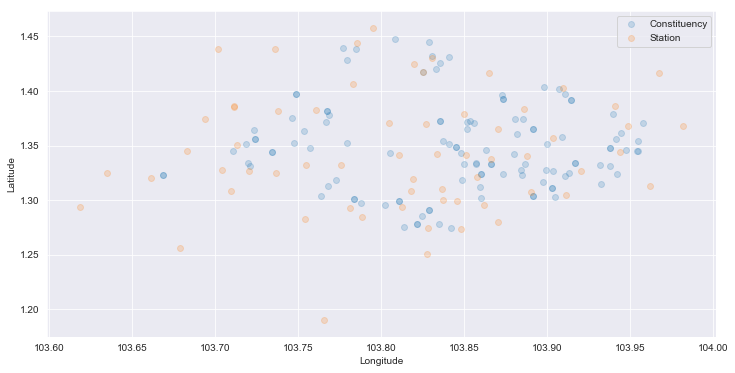

In [185]:
plt.figure(figsize=(12, 6))
plt.ylabel("Latitude")
plt.xlabel("Longitude")

plt.scatter(const_lat_long["LONGITUDE"], const_lat_long["LATITUDE"],alpha=0.2)
plt.scatter(df_station["longitude"], df_station["latitude"],alpha=0.2)
lgd = ['Constituency', 'Station']
plt.legend(lgd);
plt.show()

In [182]:
for i_consti in range(const_lat_long.shape[0]):
    min_dist = 99999
    min_station = -1
    min_station_name = -1
    min_stat_long = -1
    min_stat_lat = -1
    for i_station in range(df_station.shape[0]):
        cur_dist = ((df_station["latitude"].iloc[i_station] - const_lat_long["LATITUDE"].iloc[i_consti])**2 + \
                    (df_station["longitude"].iloc[i_station] - const_lat_long["LONGITUDE"].iloc[i_consti])**2)**0.5
        
        if cur_dist < min_dist:
            min_dist = cur_dist
            min_station = df_station["station_code"].iloc[i_station]
            min_station_name = df_station["station_name"].iloc[i_station]
            min_stat_long = df_station["longitude"].iloc[i_station]
            min_stat_lat = df_station["latitude"].iloc[i_station]
            
    const_lat_long["station_code"].iloc[i_consti] = min_station
    const_lat_long["station_name"].iloc[i_consti] = min_station_name
    const_lat_long["station_long"].iloc[i_consti] = min_stat_long
    const_lat_long["station_lat"].iloc[i_consti] = min_stat_lat

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [129]:
raw = raw_hold
raw["Daily Rainfall Total (mm)"] = pd.to_numeric( raw["Daily Rainfall Total (mm)"], errors="coerce" )
raw["Daily Rainfall Total (mm)"] = raw["Daily Rainfall Total (mm)"].fillna(0)

In [133]:
# Adding a datetime col in the year-month-day format
raw["Date"] = pd.to_datetime(
    raw["Year"].astype(str)
    + "-"
    + raw["Month"].astype(str)
    + "-"
    + raw["Day"].astype(str)
)

In [21]:
raw_hold = raw

In [22]:
raw_hold.shape

(327271, 17)

In [134]:
df_all_station = pd.merge(df_all, const_lat_long, on = "CONSTITUENCY", how = 'left')

In [135]:
raw = raw_hold
df_all_rain = pd.merge(df_all_station, raw, how = 'inner', left_on = ['station_name', 'ONSET_DATE'], right_on = ['Station', 'Date'])  
df_all_rain['dateindex'] = df_all_rain["ONSET_DATE"]
df_all_rain.set_index(df_all_rain['dateindex'], inplace=True)
df_all_rain.dateindex = pd.to_datetime(df_all_rain.dateindex, unit='s')

In [136]:
df_mth = df_all_rain.groupby(["CONSTITUENCY"]).resample('M',level=0, label='left')["OBJECTID"].count()
df_mth = df_mth.reset_index(name="count")
df_mth = pd.merge(df_mth, const_lat_long, on = "CONSTITUENCY", how = 'left')

for i in range(1,30):
    col_name = "day_b4_" + str(i)
    df_mth[col_name] = df_mth.dateindex + pd.Timedelta(days=-i)
    df_mth = pd.merge(df_mth, raw[["Daily Rainfall Total (mm)", "Station", "Date"]], how = 'inner', \
                       left_on = ['station_name', col_name ], right_on = ['Station', 'Date'])  
    col_name_rf = "day_b4_rf_" + str(i)
    df_mth.drop(columns=["Station", "Date", col_name], inplace=True)
    df_mth.rename(columns = {"Daily Rainfall Total (mm)":col_name_rf}, inplace = True)
    
df = df_mth[['count', 'LATITUDE', 'LONGITUDE',
       'day_b4_rf_1', 'day_b4_rf_2', 'day_b4_rf_3', 'day_b4_rf_4',
       'day_b4_rf_5', 'day_b4_rf_6', 'day_b4_rf_7', 'day_b4_rf_8',
       'day_b4_rf_9', 'day_b4_rf_10', 'day_b4_rf_11', 'day_b4_rf_12',
       'day_b4_rf_13', 'day_b4_rf_14', 'day_b4_rf_15', 'day_b4_rf_16',
       'day_b4_rf_17', 'day_b4_rf_18', 'day_b4_rf_19', 'day_b4_rf_20',
       'day_b4_rf_21', 'day_b4_rf_22', 'day_b4_rf_23', 'day_b4_rf_24',
       'day_b4_rf_25', 'day_b4_rf_26', 'day_b4_rf_27', 'day_b4_rf_28',
       'day_b4_rf_29']]

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,count,LATITUDE,LONGITUDE,day_b4_rf_1,day_b4_rf_2,day_b4_rf_3,day_b4_rf_4,day_b4_rf_5,day_b4_rf_6,day_b4_rf_7,day_b4_rf_8,day_b4_rf_9,day_b4_rf_10,day_b4_rf_11,day_b4_rf_12,day_b4_rf_13,day_b4_rf_14,day_b4_rf_15,day_b4_rf_16,day_b4_rf_17,day_b4_rf_18,day_b4_rf_19,day_b4_rf_20,day_b4_rf_21,day_b4_rf_22,day_b4_rf_23,day_b4_rf_24,day_b4_rf_25,day_b4_rf_26,day_b4_rf_27,day_b4_rf_28,day_b4_rf_29
count,1,-0.0596898,0.165475,-0.0388901,0.004513,-0.0141256,-0.028278,0.0209424,-0.0355224,-0.0599344,-0.0492999,-0.0626755,-0.0723522,-0.0430493,-0.0358025,0.0280545,0.0386446,-0.0284922,-0.00935416,0.0195858,-0.00109645,-0.0102573,-0.00620272,0.0126063,-0.0150629,0.0110412,0.0683338,0.0821353,0.0272387,-0.0186325,-0.0144424,-0.0446598
LATITUDE,-0.0596898,1,-0.0162757,0.0279637,0.00397475,-0.0134495,-0.0123696,-0.00802077,-0.00596229,-0.00680855,-0.0133188,0.0333972,0.046243,-0.0231784,-0.0154922,0.00996234,0.0395377,-0.00818432,0.00738979,0.0271138,0.00644572,-0.0195355,-0.00109638,-0.0122865,-0.0094581,-0.016027,0.0133787,0.0232023,-0.0026324,0.0213684,0.0158619,0.0577511
LONGITUDE,0.165475,-0.0162757,1,-0.00464839,-0.0341688,-0.0230311,-0.0243491,-0.00902772,-0.0520065,-0.0855706,-0.0733696,-0.0091946,-0.0590834,0.0160524,-0.0169398,-0.0250337,-0.0379221,0.0103754,-0.0213367,-0.0124941,-0.0385429,0.0153935,0.0153346,-0.0364649,-0.0845065,-0.0370006,0.0099996,-0.0236914,0.0109125,0.00235088,-0.00909358,0.0309861
day_b4_rf_1,-0.0388901,0.0279637,-0.00464839,1,0.1153,0.0853328,0.0223548,0.055346,0.135062,-0.0335205,0.00667289,0.012427,0.0106108,-0.030603,-0.0710692,-0.0203157,0.0404882,0.0988071,0.0616796,0.116989,0.0568072,0.0273546,-0.0371112,0.087934,-0.0185158,-0.0277449,-0.0292494,-0.00220656,0.0890616,-0.111454,-0.0162597,0.0095738
day_b4_rf_2,0.004513,0.00397475,-0.0341688,0.1153,1,0.0907852,-0.00544996,0.0437297,0.047565,0.159731,0.0267786,0.0251635,0.00987237,0.00612895,0.00278099,-0.0585678,0.0625039,-0.0350319,0.0377833,0.117793,0.0343394,-0.00214171,0.00900168,0.0634334,0.0192218,-0.00381989,0.00743394,0.0905404,0.0982141,-0.0400827,-0.0368021,0.0233587
day_b4_rf_3,-0.0141256,-0.0134495,-0.0230311,0.0853328,0.0907852,1,0.014597,0.0732545,0.0215958,0.117628,0.0268884,-0.0436137,0.0225442,-4.05317e-05,0.10763,0.038541,0.103212,-0.0389677,0.028014,0.111089,0.0562583,0.0326824,0.00224373,0.0310763,-0.023113,-0.0187471,-0.0621209,0.0162664,-0.00646915,-0.0766633,-0.0123395,-0.0411143
day_b4_rf_4,-0.028278,-0.0123696,-0.0243491,0.0223548,-0.00544996,0.014597,1,0.111856,0.0446897,0.141299,-0.00560362,-0.0103347,0.114971,0.0114576,0.0928962,0.0266201,0.0870144,-0.00401093,-0.0372039,0.0378557,0.0183875,0.00327881,0.027163,0.0154377,-0.00401605,-0.0286209,0.0407176,-0.0113108,-0.0315388,0.0410635,0.0122317,0.076846
day_b4_rf_5,0.0209424,-0.00802077,-0.00902772,0.055346,0.0437297,0.0732545,0.111856,1,0.082798,0.0827624,-0.0383869,-0.0163575,0.058731,0.00758009,0.181478,0.10967,0.22591,0.0127871,0.0390077,0.0392246,0.0286312,0.0269984,-0.0126743,-0.0200336,-0.0179368,0.0101483,0.0355866,0.0207492,-0.00723131,0.0766045,-0.028746,0.0438275
day_b4_rf_6,-0.0355224,-0.00596229,-0.0520065,0.135062,0.047565,0.0215958,0.0446897,0.082798,1,0.0452112,-0.00412863,0.00260705,0.0182273,-0.0330781,0.0726056,0.112341,0.0511029,0.0728517,0.0445391,0.108817,0.0839593,0.0554015,-0.0435945,0.010234,-0.0203926,-0.0364209,-0.064744,-0.0437931,-0.00362458,-0.0116286,0.00873726,0.00946887
day_b4_rf_7,-0.0599344,-0.00680855,-0.0855706,-0.0335205,0.159731,0.117628,0.141299,0.0827624,0.0452112,1,0.186326,0.0389944,-0.0170122,-0.0313987,0.150711,0.0461884,0.0884785,-0.0129478,0.0282903,0.0414757,0.0772515,-0.0308309,0.00747013,0.00689675,0.0457291,-0.0431059,0.0657048,-0.0217939,0.069494,-0.016992,-0.0754599,-0.0140341


In [137]:
rf_list = corr["count"][3:].to_list()

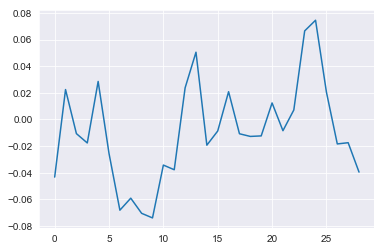

In [138]:
plt.plot(rf_series)

In [140]:
raw = raw_hold

In [141]:
# Adding a datetime col in the year-month-day format
raw["Date"] = pd.to_datetime(
    raw["Year"].astype(str)
    + "-"
    + raw["Month"].astype(str)
    + "-"
    + raw["Day"].astype(str)
)

In [142]:
raw = raw[['Maximum Temperature (°C)', 'Minimum Temperature (°C)', 'Mean Temperature (°C)', 'Day', 'Month', 'Station', 'Year']]
raw["Maximum Temperature (°C)"] = pd.to_numeric(
    raw["Maximum Temperature (°C)"], errors="coerce"
)
raw["Mean Temperature (°C)"] = pd.to_numeric(
    raw["Mean Temperature (°C)"], errors="coerce"
)
raw["Minimum Temperature (°C)"] = pd.to_numeric(
    raw["Minimum Temperature (°C)"], errors="coerce"
)

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be s

In [143]:
station_count = raw["Station"].value_counts()
station_count = station_count.reset_index()
empty_temp_list = []
filled_temp_list = []
for i in station_count["index"]:
    raw_stat = raw[raw["Station"]==i]
    
    raw_stat = raw_stat[~raw_stat["Mean Temperature (°C)"].isna()]

    if(raw_stat.shape[0] == 0):
        empty_temp_list.append(i)
    else:
        filled_temp_list.append(i)
        

In [144]:
df_station_sub = df_station[df_station["station_name"].isin(filled_temp_list)]

In [145]:
const_lat_long["station_code"] = -1
const_lat_long["station_name"] = -1
const_lat_long["station_long"] = -1
const_lat_long["station_lat"] = -1


for i_consti in range(const_lat_long.shape[0]):
    min_dist = 99999
    min_station = -1
    min_station_name = -1
    min_stat_long = -1
    min_stat_lat = -1
    for i_station in range(df_station_sub.shape[0]):
        cur_dist = ((df_station_sub["latitude"].iloc[i_station] - const_lat_long["LATITUDE"].iloc[i_consti])**2 + \
                    (df_station_sub["longitude"].iloc[i_station] - const_lat_long["LONGITUDE"].iloc[i_consti])**2)**0.5
        
        if cur_dist < min_dist:
            min_dist = cur_dist
            min_station = df_station_sub["station_code"].iloc[i_station]
            min_station_name = df_station_sub["station_name"].iloc[i_station]
            min_stat_long = df_station_sub["longitude"].iloc[i_station]
            min_stat_lat = df_station_sub["latitude"].iloc[i_station]
            
    const_lat_long["station_code"].iloc[i_consti] = min_station
    const_lat_long["station_name"].iloc[i_consti] = min_station_name
    const_lat_long["station_long"].iloc[i_consti] = min_stat_long
    const_lat_long["station_lat"].iloc[i_consti] = min_stat_lat

In [146]:
# Adding a datetime col in the year-month-day format
raw["Date"] = pd.to_datetime(
    raw["Year"].astype(str)
    + "-"
    + raw["Month"].astype(str)
    + "-"
    + raw["Day"].astype(str)
)

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [161]:
df_mth = df_all.groupby(["CONSTITUENCY"]).resample('M',level=0, label='left')["OBJECTID"].count()
df_mth = df_mth.reset_index(name="count")
df_mth = pd.merge(df_mth, const_lat_long, on = "CONSTITUENCY", how = 'left')

for i in range(1,30):
    col_name = "day_b4_" + str(i)
    df_mth[col_name] = df_mth.dateindex + pd.Timedelta(days=-i)
    df_mth = pd.merge(df_mth, raw[['Maximum Temperature (°C)', "Station", "Date"]], how = 'inner', \
                       left_on = ['station_name', col_name ], right_on = ['Station', 'Date'])  
    col_name_rf = "day_b4_maxT_" + str(i)
    df_mth.drop(columns=["Station", "Date", col_name], inplace=True)
    df_mth.rename(columns = {"Maximum Temperature (°C)":col_name_rf}, inplace = True)
    
df = df_mth[['count', 'LATITUDE', 'LONGITUDE',
       'day_b4_maxT_1', 'day_b4_maxT_2', 'day_b4_maxT_3', 'day_b4_maxT_4',
       'day_b4_maxT_5', 'day_b4_maxT_6', 'day_b4_maxT_7', 'day_b4_maxT_8',
       'day_b4_maxT_9', 'day_b4_maxT_10', 'day_b4_maxT_11', 'day_b4_maxT_12',
       'day_b4_maxT_13', 'day_b4_maxT_14', 'day_b4_maxT_15', 'day_b4_maxT_16',
       'day_b4_maxT_17', 'day_b4_maxT_18', 'day_b4_maxT_19', 'day_b4_maxT_20',
       'day_b4_maxT_21', 'day_b4_maxT_22', 'day_b4_maxT_23', 'day_b4_maxT_24',
       'day_b4_maxT_25', 'day_b4_maxT_26', 'day_b4_maxT_27', 'day_b4_maxT_28',
       'day_b4_maxT_29']]

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,count,LATITUDE,LONGITUDE,day_b4_maxT_1,day_b4_maxT_2,day_b4_maxT_3,day_b4_maxT_4,day_b4_maxT_5,day_b4_maxT_6,day_b4_maxT_7,day_b4_maxT_8,day_b4_maxT_9,day_b4_maxT_10,day_b4_maxT_11,day_b4_maxT_12,day_b4_maxT_13,day_b4_maxT_14,day_b4_maxT_15,day_b4_maxT_16,day_b4_maxT_17,day_b4_maxT_18,day_b4_maxT_19,day_b4_maxT_20,day_b4_maxT_21,day_b4_maxT_22,day_b4_maxT_23,day_b4_maxT_24,day_b4_maxT_25,day_b4_maxT_26,day_b4_maxT_27,day_b4_maxT_28,day_b4_maxT_29
count,1,-0.0742574,0.117399,0.0452318,-0.0487756,0.0458381,-0.0232251,0.0203924,0.0875398,0.0275287,0.0729677,0.0378188,0.0624267,0.0189356,0.0262924,-0.0681702,0.0264298,0.0100418,-0.0530482,0.00845544,0.00341298,0.0522647,0.0237691,0.0536144,0.0227247,-0.0302033,0.031294,-0.0190464,-0.000675062,0.0333449,0.0586562,0.0299582
LATITUDE,-0.0742574,1,-0.0124354,0.129664,0.148832,0.150503,0.145042,0.132924,0.127828,0.132026,0.14743,0.153247,0.148235,0.143605,0.141341,0.154286,0.148262,0.122212,0.176272,0.126901,0.146324,0.138347,0.146759,0.139408,0.14334,0.118746,0.136121,0.140135,0.135492,0.168681,0.129965,0.13641
LONGITUDE,0.117399,-0.0124354,1,0.00528401,-0.0106144,-0.0302463,-0.0422919,-0.0212304,-0.0457533,-0.0457356,-0.0317995,-0.00874688,-0.071079,-0.0302344,-0.0104558,-0.00917231,-0.0420317,-0.0368582,-0.0121727,-0.0647678,-0.0281932,-0.0480146,-0.00936898,-0.0296735,-0.0260688,-0.0455187,-0.00936221,-0.0255479,-0.0192648,-0.0197457,-0.026462,-0.0208149
day_b4_maxT_1,0.0452318,0.129664,0.00528401,1,0.48044,0.565705,0.378425,0.493517,0.369538,0.318934,0.395967,0.301084,0.334302,0.22799,0.415607,0.295499,0.334705,0.330818,0.2163,0.250809,0.248594,0.161911,0.238435,0.317426,0.30029,0.297982,0.27518,0.290834,0.0989073,0.346796,0.222876,0.240988
day_b4_maxT_2,-0.0487756,0.148832,-0.0106144,0.48044,1,0.48455,0.408483,0.449279,0.450101,0.470979,0.384882,0.254712,0.257825,0.307432,0.315983,0.276094,0.21759,0.205634,0.361022,0.18595,0.216474,0.161834,0.380137,0.212202,0.245533,0.262938,0.2984,0.215792,0.179254,0.250413,0.149755,0.257337
day_b4_maxT_3,0.0458381,0.150503,-0.0302463,0.565705,0.48455,1,0.395826,0.558927,0.462442,0.398723,0.421649,0.352917,0.310053,0.255993,0.368255,0.28371,0.323515,0.235107,0.252048,0.247802,0.251312,0.230057,0.350035,0.302906,0.370661,0.292096,0.197933,0.271419,0.245307,0.325218,0.226619,0.284035
day_b4_maxT_4,-0.0232251,0.145042,-0.0422919,0.378425,0.408483,0.395826,1,0.463748,0.45991,0.276509,0.370329,0.179461,0.298053,0.196291,0.191323,0.267183,0.221948,0.154047,0.294747,0.224578,0.279934,0.22455,0.242399,0.174187,0.276714,0.178777,0.325201,0.193474,0.225222,0.290617,0.128267,0.199363
day_b4_maxT_5,0.0203924,0.132924,-0.0212304,0.493517,0.449279,0.558927,0.463748,1,0.523508,0.478877,0.47736,0.338436,0.317344,0.20966,0.376362,0.345731,0.364877,0.2918,0.2663,0.275455,0.260237,0.244717,0.356738,0.267593,0.31493,0.323581,0.267367,0.29431,0.169739,0.307358,0.223722,0.219267
day_b4_maxT_6,0.0875398,0.127828,-0.0457533,0.369538,0.450101,0.462442,0.45991,0.523508,1,0.472421,0.457541,0.301461,0.351079,0.297448,0.326145,0.312351,0.34983,0.286719,0.290607,0.304266,0.329421,0.328126,0.328033,0.260255,0.317862,0.268503,0.274686,0.182472,0.190409,0.260219,0.238777,0.288579
day_b4_maxT_7,0.0275287,0.132026,-0.0457356,0.318934,0.470979,0.398723,0.276509,0.478877,0.472421,1,0.508187,0.449315,0.391126,0.370117,0.429395,0.312322,0.348445,0.244233,0.359584,0.257804,0.300804,0.259642,0.35524,0.221918,0.288023,0.365509,0.260261,0.27083,0.264953,0.195999,0.302398,0.251258


In [162]:
maxT_list = corr["count"][3:].to_list()

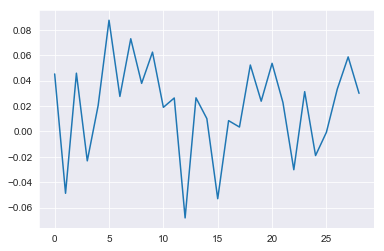

In [163]:
plt.plot(maxT_list)

In [158]:
df_mth = df_all.groupby(["CONSTITUENCY"]).resample('M',level=0, label='left')["OBJECTID"].count()
df_mth = df_mth.reset_index(name="count")
df_mth = pd.merge(df_mth, const_lat_long, on = "CONSTITUENCY", how = 'left')

for i in range(1,30):
    col_name = "day_b4_" + str(i)
    df_mth[col_name] = df_mth.dateindex + pd.Timedelta(days=-i)
    df_mth = pd.merge(df_mth, raw[['Minimum Temperature (°C)', "Station", "Date"]], how = 'inner', \
                       left_on = ['station_name', col_name ], right_on = ['Station', 'Date'])  
    col_name_rf = "day_b4_minT_" + str(i)
    df_mth.drop(columns=["Station", "Date", col_name], inplace=True)
    df_mth.rename(columns = {"Minimum Temperature (°C)":col_name_rf}, inplace = True)
    
df = df_mth[['count', 'LATITUDE', 'LONGITUDE',
       'day_b4_minT_1', 'day_b4_minT_2', 'day_b4_minT_3', 'day_b4_minT_4',
       'day_b4_minT_5', 'day_b4_minT_6', 'day_b4_minT_7', 'day_b4_minT_8',
       'day_b4_minT_9', 'day_b4_minT_10', 'day_b4_minT_11', 'day_b4_minT_12',
       'day_b4_minT_13', 'day_b4_minT_14', 'day_b4_minT_15', 'day_b4_minT_16',
       'day_b4_minT_17', 'day_b4_minT_18', 'day_b4_minT_19', 'day_b4_minT_20',
       'day_b4_minT_21', 'day_b4_minT_22', 'day_b4_minT_23', 'day_b4_minT_24',
       'day_b4_minT_25', 'day_b4_minT_26', 'day_b4_minT_27', 'day_b4_minT_28',
       'day_b4_minT_29']]

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,count,LATITUDE,LONGITUDE,day_b4_minT_1,day_b4_minT_2,day_b4_minT_3,day_b4_minT_4,day_b4_minT_5,day_b4_minT_6,day_b4_minT_7,day_b4_minT_8,day_b4_minT_9,day_b4_minT_10,day_b4_minT_11,day_b4_minT_12,day_b4_minT_13,day_b4_minT_14,day_b4_minT_15,day_b4_minT_16,day_b4_minT_17,day_b4_minT_18,day_b4_minT_19,day_b4_minT_20,day_b4_minT_21,day_b4_minT_22,day_b4_minT_23,day_b4_minT_24,day_b4_minT_25,day_b4_minT_26,day_b4_minT_27,day_b4_minT_28,day_b4_minT_29
count,1,-0.0742574,0.117399,0.0869683,0.128643,0.129655,0.0802833,0.0295611,0.163572,0.176554,0.196116,0.170593,0.212912,0.142642,0.105029,0.087175,0.157212,0.122925,0.0884355,0.127475,0.0975197,0.114191,0.12844,0.16196,0.0893508,0.0936206,0.0489709,0.0713984,0.0948628,0.132337,0.184921,0.130739
LATITUDE,-0.0742574,1,-0.0124354,-0.261686,-0.217818,-0.240191,-0.21547,-0.233837,-0.266152,-0.304416,-0.26911,-0.262896,-0.264853,-0.24097,-0.261326,-0.223608,-0.21959,-0.266707,-0.215596,-0.25865,-0.254749,-0.25589,-0.238326,-0.22741,-0.231645,-0.255309,-0.19707,-0.220758,-0.224048,-0.209386,-0.255745,-0.250335
LONGITUDE,0.117399,-0.0124354,1,0.124044,0.169346,0.188791,0.139228,0.147463,0.15013,0.162659,0.166122,0.143918,0.149421,0.127114,0.153649,0.141697,0.159498,0.148336,0.130708,0.138381,0.154142,0.132158,0.128436,0.167543,0.174295,0.164758,0.142399,0.157959,0.143248,0.130602,0.142019,0.135901
day_b4_minT_1,0.0869683,-0.261686,0.124044,1,0.52281,0.508779,0.454781,0.521417,0.477655,0.548961,0.439768,0.384761,0.444757,0.471785,0.47212,0.431434,0.428748,0.415291,0.320451,0.369781,0.41286,0.340321,0.417585,0.287856,0.391312,0.421095,0.372578,0.343094,0.304418,0.159646,0.333602,0.309487
day_b4_minT_2,0.128643,-0.217818,0.169346,0.52281,1,0.498492,0.473661,0.334455,0.430589,0.458645,0.433334,0.428354,0.430759,0.456527,0.333252,0.31329,0.276738,0.327303,0.330879,0.329983,0.355366,0.362306,0.450213,0.288296,0.30354,0.286222,0.357538,0.259473,0.353228,0.221188,0.263983,0.29053
day_b4_minT_3,0.129655,-0.240191,0.188791,0.508779,0.498492,1,0.426869,0.438764,0.442173,0.498981,0.414553,0.395856,0.422833,0.427863,0.419847,0.348871,0.250875,0.273621,0.337409,0.380478,0.354676,0.290987,0.378061,0.309221,0.304427,0.325669,0.337391,0.378317,0.343698,0.223627,0.343577,0.387738
day_b4_minT_4,0.0802833,-0.21547,0.139228,0.454781,0.473661,0.426869,1,0.432705,0.356369,0.332409,0.422274,0.364486,0.348821,0.240857,0.172302,0.252704,0.255714,0.288349,0.219013,0.177027,0.192647,0.33819,0.310845,0.170531,0.382599,0.250491,0.279142,0.270701,0.344741,0.207749,0.200177,0.208594
day_b4_minT_5,0.0295611,-0.233837,0.147463,0.521417,0.334455,0.438764,0.432705,1,0.535073,0.453471,0.340389,0.314856,0.401869,0.328771,0.37631,0.337718,0.229307,0.297355,0.291508,0.283697,0.386409,0.336222,0.321494,0.281808,0.289419,0.332704,0.28354,0.38098,0.309903,0.294203,0.342874,0.331592
day_b4_minT_6,0.163572,-0.266152,0.15013,0.477655,0.430589,0.442173,0.356369,0.535073,1,0.617563,0.531161,0.542479,0.540343,0.515628,0.47357,0.464453,0.313997,0.411377,0.447256,0.439813,0.498149,0.426682,0.34455,0.33024,0.31958,0.285513,0.242862,0.360964,0.392903,0.332012,0.428232,0.403717
day_b4_minT_7,0.176554,-0.304416,0.162659,0.548961,0.458645,0.498981,0.332409,0.453471,0.617563,1,0.681521,0.559563,0.621934,0.592132,0.557767,0.524001,0.422793,0.474773,0.45211,0.48221,0.430903,0.399387,0.411741,0.352825,0.329198,0.348057,0.355813,0.438317,0.378119,0.274832,0.405432,0.410355


In [159]:
minT_list = corr["count"][3:].to_list()

In [166]:
df_mth = df_all.groupby(["CONSTITUENCY"]).resample('M',level=0, label='left')["OBJECTID"].count()
df_mth = df_mth.reset_index(name="count")
df_mth = pd.merge(df_mth, const_lat_long, on = "CONSTITUENCY", how = 'left')

for i in range(1,30):
    col_name = "day_b4_" + str(i)
    df_mth[col_name] = df_mth.dateindex + pd.Timedelta(days=-i)
    df_mth = pd.merge(df_mth, raw[['Mean Temperature (°C)', "Station", "Date"]], how = 'inner', \
                       left_on = ['station_name', col_name ], right_on = ['Station', 'Date'])  
    col_name_rf = "day_b4_meanT_" + str(i)
    df_mth.drop(columns=["Station", "Date", col_name], inplace=True)
    df_mth.rename(columns = {"Mean Temperature (°C)":col_name_rf}, inplace = True)
    
df = df_mth[['count', 'LATITUDE', 'LONGITUDE',
       'day_b4_meanT_1', 'day_b4_meanT_2', 'day_b4_meanT_3', 'day_b4_meanT_4',
       'day_b4_meanT_5', 'day_b4_meanT_6', 'day_b4_meanT_7', 'day_b4_meanT_8',
       'day_b4_meanT_9', 'day_b4_meanT_10', 'day_b4_meanT_11',
       'day_b4_meanT_12', 'day_b4_meanT_13', 'day_b4_meanT_14',
       'day_b4_meanT_15', 'day_b4_meanT_16', 'day_b4_meanT_17',
       'day_b4_meanT_18', 'day_b4_meanT_19', 'day_b4_meanT_20',
       'day_b4_meanT_21', 'day_b4_meanT_22', 'day_b4_meanT_23',
       'day_b4_meanT_24', 'day_b4_meanT_25', 'day_b4_meanT_26',
       'day_b4_meanT_27', 'day_b4_meanT_28', 'day_b4_meanT_29']]

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,count,LATITUDE,LONGITUDE,day_b4_meanT_1,day_b4_meanT_2,day_b4_meanT_3,day_b4_meanT_4,day_b4_meanT_5,day_b4_meanT_6,day_b4_meanT_7,day_b4_meanT_8,day_b4_meanT_9,day_b4_meanT_10,day_b4_meanT_11,day_b4_meanT_12,day_b4_meanT_13,day_b4_meanT_14,day_b4_meanT_15,day_b4_meanT_16,day_b4_meanT_17,day_b4_meanT_18,day_b4_meanT_19,day_b4_meanT_20,day_b4_meanT_21,day_b4_meanT_22,day_b4_meanT_23,day_b4_meanT_24,day_b4_meanT_25,day_b4_meanT_26,day_b4_meanT_27,day_b4_meanT_28,day_b4_meanT_29
count,1,-0.0742574,0.117399,0.114738,0.0876425,0.148386,0.104271,0.0987139,0.181781,0.141926,0.193671,0.15953,0.186174,0.136642,0.121962,0.0952041,0.154998,0.118231,0.103767,0.144184,0.125295,0.137166,0.134578,0.141473,0.101728,0.0712896,0.0857747,0.0732143,0.0853428,0.152004,0.152155,0.13608
LATITUDE,-0.0742574,1,-0.0124354,-0.162188,-0.132945,-0.121298,-0.132195,-0.128411,-0.137558,-0.152007,-0.131322,-0.128073,-0.131727,-0.100791,-0.0937762,-0.0993687,-0.111478,-0.131241,-0.103343,-0.129793,-0.124698,-0.134847,-0.117386,-0.112761,-0.109409,-0.130984,-0.11114,-0.107533,-0.128384,-0.0919106,-0.123847,-0.104056
LONGITUDE,0.117399,-0.0124354,1,0.129689,0.12615,0.126881,0.123728,0.12437,0.114646,0.105619,0.112173,0.108004,0.113812,0.0895844,0.0920341,0.130477,0.113585,0.109156,0.107832,0.106754,0.115389,0.0886724,0.118285,0.1232,0.126969,0.108016,0.103357,0.0961722,0.107916,0.107991,0.109042,0.111878
day_b4_meanT_1,0.114738,-0.162188,0.129689,1,0.727079,0.685773,0.569,0.629484,0.523502,0.577133,0.487623,0.418874,0.513901,0.443784,0.49652,0.471287,0.447725,0.415912,0.346286,0.410123,0.370882,0.31595,0.370508,0.353312,0.390472,0.440789,0.412275,0.364641,0.273288,0.262815,0.334603,0.307439
day_b4_meanT_2,0.0876425,-0.132945,0.12615,0.727079,1,0.711473,0.59875,0.608584,0.598041,0.654092,0.551702,0.503139,0.496698,0.512063,0.482096,0.437393,0.398128,0.399586,0.445273,0.427526,0.459234,0.396586,0.511397,0.37408,0.438594,0.400268,0.395828,0.395472,0.419265,0.400394,0.367876,0.420607
day_b4_meanT_3,0.148386,-0.121298,0.126881,0.685773,0.711473,1,0.61723,0.65039,0.609727,0.621448,0.568889,0.524949,0.511532,0.479637,0.500937,0.428865,0.378395,0.322007,0.376784,0.436119,0.388277,0.388813,0.45801,0.373906,0.438547,0.429468,0.337488,0.416518,0.386617,0.428379,0.440086,0.450767
day_b4_meanT_4,0.104271,-0.132195,0.123728,0.569,0.59875,0.61723,1,0.660523,0.54412,0.466087,0.526287,0.423409,0.474059,0.358329,0.353599,0.385422,0.293799,0.278887,0.315813,0.300172,0.293151,0.357165,0.371337,0.244917,0.381964,0.344656,0.349165,0.33178,0.37615,0.444344,0.282603,0.323488
day_b4_meanT_5,0.0987139,-0.128411,0.12437,0.629484,0.608584,0.65039,0.660523,1,0.710843,0.645579,0.551289,0.452181,0.524524,0.420544,0.466647,0.475964,0.37719,0.409179,0.364668,0.367339,0.378388,0.391768,0.38636,0.368482,0.43906,0.426618,0.412349,0.403959,0.337077,0.418524,0.410652,0.382717
day_b4_meanT_6,0.181781,-0.137558,0.114646,0.523502,0.598041,0.609727,0.54412,0.710843,1,0.738338,0.649822,0.564925,0.556027,0.509913,0.527855,0.543838,0.479032,0.482577,0.473674,0.49182,0.54754,0.550648,0.428228,0.36907,0.468194,0.398062,0.374575,0.394735,0.426238,0.398249,0.522256,0.422952
day_b4_meanT_7,0.141926,-0.152007,0.105619,0.577133,0.654092,0.621448,0.466087,0.645579,0.738338,1,0.750554,0.630491,0.62328,0.606788,0.617732,0.526128,0.450751,0.456852,0.437073,0.471409,0.4838,0.432287,0.46892,0.384976,0.482191,0.452993,0.425328,0.474609,0.401624,0.368817,0.451437,0.403243


In [167]:
meanT_list = corr["count"][3:].to_list()

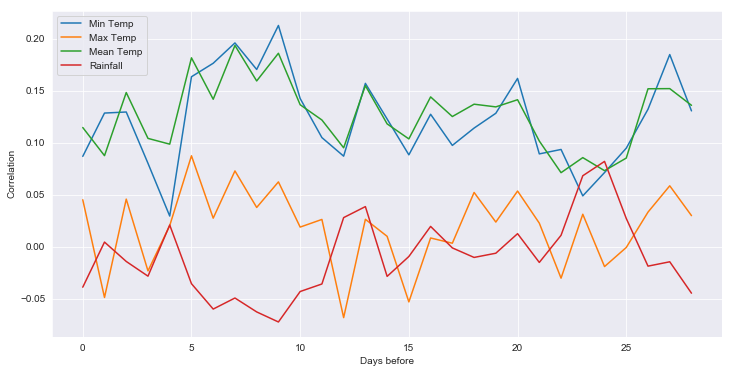

In [173]:
plt.figure(figsize=(12, 6))
plt.plot(minT_list)
plt.plot(maxT_list)
plt.plot(meanT_list)
plt.plot(rf_list)
plt.xlabel("Days before")
plt.ylabel("Correlation")
lgd = ["Min Temp", "Max Temp", "Mean Temp", "Rainfall"]
plt.legend(lgd,loc='upper left');
plt.show()

In [39]:
df_mth = df_all.groupby(["CONSTITUENCY"]).resample('M',level=0, label='left')["OBJECTID"].count()
df_mth = df_mth.reset_index(name="count")


df_mth = pd.merge(df_mth, const_lat_long, on = "CONSTITUENCY", how = 'left')


df_mth = pd.merge(df_mth, raw[['Minimum Temperature (°C)', "Station", "Date"]], how = 'inner', \
                       left_on = ['station_name', 'dateindex' ], right_on = ['Station', 'Date']) 


df_mth.set_index(df_mth['dateindex'], inplace=True)
df_mth.dateindex = pd.to_datetime(df_mth.dateindex, unit='s')
df_av_temp = df_mth.groupby(["CONSTITUENCY"]).resample('M',level=0, label='left')["Minimum Temperature (°C)"].mean()
df_av_temp = df_av_temp.reset_index(name="mean")

for i in range(1,16):
    col_name = "mth_b4_" + str(i)
    df_mth[col_name] = df_mth["Date"] + pd.DateOffset(months=-i) + pd.offsets.MonthEnd(0)
    df_mth.drop(columns=['dateindex'], inplace=True)
    df_mth = pd.merge(df_mth, df_av_temp, how = 'inner', \
                       left_on = ['CONSTITUENCY', col_name], right_on = ['CONSTITUENCY', 'dateindex'])  
    col_name_rf = "mth_b4_meanT_" + str(i)
   # df_mth.drop(columns=[col_name, 'dateindex_x', 'dateindex_y'], inplace=True)
    df_mth.rename(columns = {"mean":col_name_rf}, inplace = True)

    
df_prev_meantemp = df_mth[['Date', 'count', 'CONSTITUENCY',
       'mth_b4_meanT_1', 'mth_b4_meanT_2',
       'mth_b4_meanT_3', 'mth_b4_meanT_4',
       'mth_b4_meanT_5', 'mth_b4_meanT_6',
       'mth_b4_meanT_7', 'mth_b4_meanT_8',
       'mth_b4_meanT_9', 'mth_b4_meanT_10', 
       'mth_b4_meanT_11','mth_b4_meanT_12',
       'mth_b4_meanT_13','mth_b4_meanT_14', 'mth_b4_meanT_15']]

In [155]:
df_mth = df_all.groupby(["CONSTITUENCY"]).resample('M',level=0, label='left')["OBJECTID"].count()
df_mth = df_mth.reset_index(name="count")
df_mth = pd.merge(df_mth, const_lat_long, on = "CONSTITUENCY", how = 'left')

df_mth_copy = df_mth.copy()

df_mth_copy.rename(columns = {'CONSTITUENCY':'CONSTITUENCY_c', 'dateindex': 'dateindex_c', 'count': 'count_c', \
                               'LATITUDE':'LATITUDE_c', 'LONGITUDE':'LONGITUDE_c', 'station_code': 'station_code_c', \
                               'station_name':'station_name_c', 'station_long':'station_long_c', 'station_lat':'station_lat_c'}, inplace = True)

for i in range(1,16):
    col_name = "mth_b4_" + str(i)
    df_mth[col_name] = df_mth["dateindex"] + pd.DateOffset(months=-i) + pd.offsets.MonthEnd(0)

    df_mth = pd.merge(df_mth, df_mth_copy[["count_c", "CONSTITUENCY_c", "dateindex_c"]], how = 'inner', \
                        left_on = ['CONSTITUENCY', col_name], right_on = ['CONSTITUENCY_c', 'dateindex_c'])  
    
    col_name_prev = "mth_b4_prev_" + str(i)

#    df_mth.drop(columns=["dateindex_c", "CONSTITUENCY_c", col_name], inplace=True)
    
    df_mth.rename(columns = {"count_c":col_name_prev}, inplace = True)
    
df_prev_cnt = df_mth[['count', 'LATITUDE', 'LONGITUDE', 'CONSTITUENCY', 'dateindex',
       'mth_b4_prev_1', 'mth_b4_prev_2', 'mth_b4_prev_3', 'mth_b4_prev_4',
       'mth_b4_prev_5', 'mth_b4_prev_6', 'mth_b4_prev_7', 'mth_b4_prev_8',
       'mth_b4_prev_9', 'mth_b4_prev_10', 'mth_b4_prev_11', 'mth_b4_prev_12',
        'mth_b4_prev_13', 'mth_b4_prev_14', 'mth_b4_prev_15']]

corr = df_prev_cnt.corr()
corr.style.background_gradient(cmap='coolwarm')

,count,LATITUDE,LONGITUDE,mth_b4_prev_1,mth_b4_prev_2,mth_b4_prev_3,mth_b4_prev_4,mth_b4_prev_5,mth_b4_prev_6,mth_b4_prev_7,mth_b4_prev_8,mth_b4_prev_9,mth_b4_prev_10,mth_b4_prev_11,mth_b4_prev_12,mth_b4_prev_13,mth_b4_prev_14,mth_b4_prev_15
count,1,-0.0641276,0.1117,0.785529,0.659049,0.589068,0.535727,0.488822,0.450807,0.414634,0.382319,0.362081,0.347583,0.345559,0.331677,0.31629,0.298992,0.277908
LATITUDE,-0.0641276,1,-0.0506031,-0.0660143,-0.0666072,-0.0666527,-0.0669225,-0.067103,-0.0675234,-0.0681899,-0.0679993,-0.0674452,-0.0672916,-0.0666893,-0.066196,-0.0651229,-0.0638453,-0.0623418
LONGITUDE,0.1117,-0.0506031,1,0.111143,0.11062,0.108927,0.107383,0.106191,0.105229,0.104462,0.103049,0.102141,0.101342,0.100251,0.0989561,0.0974257,0.0958922,0.0949931
mth_b4_prev_1,0.785529,-0.0660143,0.111143,1,0.787272,0.662473,0.592657,0.536265,0.489346,0.451744,0.415148,0.383687,0.362738,0.347966,0.344088,0.331195,0.316096,0.298203
mth_b4_prev_2,0.659049,-0.0666072,0.11062,0.787272,1,0.789359,0.664277,0.592378,0.535914,0.489742,0.4513,0.415139,0.383517,0.362037,0.346921,0.342905,0.33034,0.315018
mth_b4_prev_3,0.589068,-0.0666527,0.108927,0.662473,0.789359,1,0.7881,0.662794,0.591036,0.535613,0.488456,0.450854,0.414922,0.38311,0.360739,0.346448,0.341842,0.329397
mth_b4_prev_4,0.535727,-0.0669225,0.107383,0.592657,0.664277,0.7881,1,0.788642,0.663003,0.591922,0.536014,0.489097,0.451946,0.415714,0.383358,0.361539,0.346959,0.342888
mth_b4_prev_5,0.488822,-0.067103,0.106191,0.536265,0.592378,0.662794,0.788642,1,0.7897,0.664216,0.592568,0.536642,0.489782,0.452644,0.415999,0.383864,0.362181,0.347563
mth_b4_prev_6,0.450807,-0.0675234,0.105229,0.489346,0.535914,0.591036,0.663003,0.7897,1,0.789253,0.664719,0.593986,0.537672,0.491235,0.453011,0.41748,0.385306,0.363369
mth_b4_prev_7,0.414634,-0.0681899,0.104462,0.451744,0.489742,0.535613,0.591922,0.664216,0.789253,1,0.790002,0.66635,0.595398,0.539647,0.492109,0.455376,0.420064,0.387586


In [40]:
df_model_data = pd.merge(df_prev_cnt, df_prev_meantemp, how = 'inner', \
                       left_on = ['CONSTITUENCY', 'dateindex' ], right_on = ['CONSTITUENCY', 'Date']) 

In [41]:
df_model_data[['count_x', 'count_y']].head()

,count_x,count_y
0,1,1
1,3,3
2,1,1
3,1,1
4,3,3


In [43]:
df_model_data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [56]:
df_model_data["month"] = df_model_data["dateindex"].dt.month

In [44]:
df_model_data.shape

(6540, 37)

In [57]:
#drop rows with no date or unreasonable dates
date_lower = datetime.date(2014,5,1)
date_upper = datetime.date(2016,1,1)

date_after = datetime.date(2011,1,1)

df_model_interval = df_model_data[df_model_data["dateindex"] < date_lower]
df_model_interval = df_model_interval.append(df_model_data[df_model_data["dateindex"] > date_upper])

df_model_after = df_model_data[df_model_data["dateindex"] > date_after]

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  import sys
C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to

In [58]:
sel_feature = ['LATITUDE', 'LONGITUDE', 'month',
      'mth_b4_prev_4', 'mth_b4_prev_5',
       'mth_b4_prev_6', 'mth_b4_prev_7', 'mth_b4_prev_8',
       'mth_b4_prev_9', 'mth_b4_prev_10', 'mth_b4_prev_11', 'mth_b4_prev_12',
       'mth_b4_prev_13', 'mth_b4_prev_14', 'mth_b4_prev_15',
        'mth_b4_meanT_4', 'mth_b4_meanT_5',
        'mth_b4_meanT_6', 'mth_b4_meanT_7', 'mth_b4_meanT_8',
       'mth_b4_meanT_9', 'mth_b4_meanT_10', 'mth_b4_meanT_11',
       'mth_b4_meanT_12', 
        'mth_b4_meanT_13', 'mth_b4_meanT_14','mth_b4_meanT_15'
              ]

In [59]:
df_model_interval.columns

Index(['count_x', 'LATITUDE', 'LONGITUDE', 'CONSTITUENCY', 'dateindex',
       'mth_b4_prev_1', 'mth_b4_prev_2', 'mth_b4_prev_3', 'mth_b4_prev_4',
       'mth_b4_prev_5', 'mth_b4_prev_6', 'mth_b4_prev_7', 'mth_b4_prev_8',
       'mth_b4_prev_9', 'mth_b4_prev_10', 'mth_b4_prev_11', 'mth_b4_prev_12',
       'mth_b4_prev_13', 'mth_b4_prev_14', 'mth_b4_prev_15', 'Date', 'count_y',
       'mth_b4_meanT_1', 'mth_b4_meanT_2', 'mth_b4_meanT_3', 'mth_b4_meanT_4',
       'mth_b4_meanT_5', 'mth_b4_meanT_6', 'mth_b4_meanT_7', 'mth_b4_meanT_8',
       'mth_b4_meanT_9', 'mth_b4_meanT_10', 'mth_b4_meanT_11',
       'mth_b4_meanT_12', 'mth_b4_meanT_13', 'mth_b4_meanT_14',
       'mth_b4_meanT_15', 'month'],
      dtype='object')

In [60]:
X = df_model_interval[sel_feature]
y = df_model_interval[['count_x']]

y = df_model_interval[['count_x']]

In [61]:
X_for_test = df_model_after[['dateindex', 
                             'LATITUDE', 'LONGITUDE', 'month',
        'mth_b4_prev_3', 'mth_b4_prev_4', 'mth_b4_prev_5',
       'mth_b4_prev_6', 'mth_b4_prev_7', 'mth_b4_prev_8',
       'mth_b4_prev_9', 'mth_b4_prev_10', 'mth_b4_prev_11', 'mth_b4_prev_12',
       'mth_b4_prev_13', 'mth_b4_prev_14', 'mth_b4_prev_15',
        'mth_b4_meanT_3', 'mth_b4_meanT_4', 'mth_b4_meanT_5',
        'mth_b4_meanT_6', 'mth_b4_meanT_7', 'mth_b4_meanT_8',
       'mth_b4_meanT_9', 'mth_b4_meanT_10', 'mth_b4_meanT_11',
       'mth_b4_meanT_12', 'mth_b4_meanT_13', 'mth_b4_meanT_14',
       'mth_b4_meanT_15'
   ]]
y_for_test = df_model_after[['dateindex', 'count_x']]

In [62]:
X = df_model_interval[sel_feature]
y = df_model_interval[['count_x']]

In [63]:
X = X.to_numpy()
y = y.to_numpy()

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [85]:
GBoost = GradientBoostingRegressor(alpha=0.8, n_estimators=2000, 
                                        learning_rate=0.075, max_depth=4, max_features='auto',
                                           min_samples_leaf=1, min_samples_split=10, 
                                               loss='huber', random_state=5)

GBoost.fit(X_train, y_train) #training the algorithm
y_pred = GBoost.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#score = rmsle_cv(GBoost)
#print("\nGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 4.371479061802911
Mean Squared Error: 71.15480878948036
Root Mean Squared Error: 8.435330982805615


In [67]:
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
ENet.fit(X_train, y_train) #training the algorithm
y_pred = ENet.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.3794420243894585
Mean Squared Error: 97.24077577937466
Root Mean Squared Error: 9.861073764016506


In [69]:
X_test

array([[  1.29913482, 103.81093584,   7.        , ...,  24.2       ,
         26.3       ,  25.3       ],
       [  1.36560908, 103.85199848,   4.        , ...,  25.3       ,
         22.9       ,  25.4       ],
       [  1.3813311 , 103.76760368,   5.        , ...,  24.7       ,
         23.9       ,  26.        ],
       ...,
       [  1.30197618, 103.86049618,   6.        , ...,  25.2       ,
         25.3       ,  25.2       ],
       [  1.30387304, 103.76384391,   3.        , ...,  26.6       ,
         24.5       ,  23.1       ],
       [  1.37398619, 103.88544011,  10.        , ...,  25.3       ,
         23.3       ,  25.2       ]])

In [70]:
y_pred = X_test[:,3]
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.7688540646425075
Mean Squared Error: 122.66405484818804
Root Mean Squared Error: 11.075380573514757


In [74]:
pred_mth = 60
start_date = datetime.date(2011,1,31)

In [76]:
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

In [84]:
GBoost = GradientBoostingRegressor(alpha=0.8, n_estimators=2000, 
                                        learning_rate=0.075, max_depth=4, max_features='auto',
                                           min_samples_leaf=1, min_samples_split=10, 
                                               loss='huber', random_state=5)

GBoost.fit(X_train, y_train) #training the algorithm
y_pred = GBoost.predict(X_test)
print(GBoost.get_params())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

datelist = []
predlist = []
actuallist = []
naivelist = []
for i in range(0,pred_mth):

    date_index = start_date + pd.DateOffset(months=i) + pd.offsets.MonthEnd(0)
    X_quick = X_for_test[X_for_test["dateindex"] == date_index]
    y_quick = y_for_test[y_for_test["dateindex"] == date_index]

    X_quick = X_quick[sel_feature]
    y_quick = y_quick[['count_x']]

    try:
        quick_test_pred = GBoost.predict(X_quick)

        datelist.append(date_index)
        predlist.append(quick_test_pred.sum())
        actuallist.append(y_quick['count_x'].sum())
        naivelist.append(X_quick.sum()[3])
    except:
        pass



C:\Users\16808949_admin\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'alpha': 0.8, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.075, 'loss': 'huber', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2000, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': 5, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Mean Absolute Error: 4.371479061802911
Mean Squared Error: 71.15480878948036
Root Mean Squared Error: 8.435330982805615


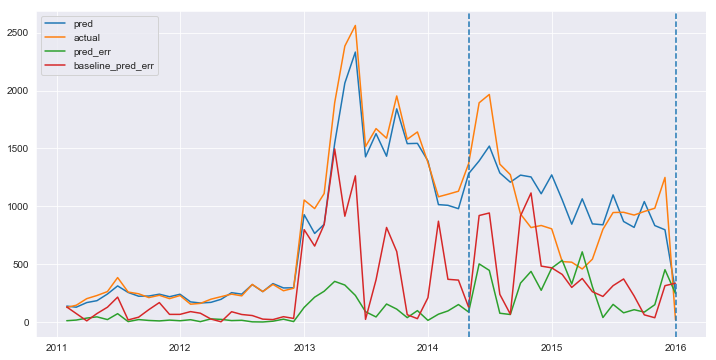

In [80]:
# Plot the data with Matplotlib defaults
plt.figure(figsize=(12, 6))
plt.plot(datelist, predlist)
#plt.plot(datelist, naivelist)
plt.plot(datelist, actuallist)
plt.plot(datelist, abs(np.subtract(actuallist,predlist)))
plt.plot(datelist, abs(np.subtract(actuallist,naivelist)))
plt.axvline(date_upper,linestyle='--')
plt.axvline(date_lower,linestyle='--')
lgd = ["pred", "actual", "pred_err", "baseline_pred_err"]
plt.legend(lgd,loc='upper left');
plt.show()